In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import re

##### Read features as dataframes

In [2]:
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [3]:
region_en = 'xinan'

In [4]:
# import the points with image values 
feature_df = [pd.read_csv(f'./Data/Training_sample_{region_en}_{year}.csv') for year in year_range]

# merge all pt_with_img and remove unnecessary columns
feature_df = [fe.drop(['system:index','.geo'],axis=1) for fe in feature_df]

##### train_test_split and apply randomforest_classifier

In [5]:
Sample_acc = {}

for year,fe in zip(year_range,feature_df):
    
    # _______________________________Different band combination_______________________________
    
    col_name = ''.join(fe.columns)
    
    # find the spectrum band names
    Spectrum_reg = re.compile(r'(B6_VCID_\d|B\d{1,2}|Landsat_B\d{1,2}|Sentinel_B\d{1,2}A?)')
    Spectrum_reg_bands = Spectrum_reg.findall(col_name)
    
    # find the Mean-nomalized names
    Mean_nomalize_bands = ['NDVI','NDBI','EVI']
    
    # find the Fourire names
    Fourier_reg   = re.compile(r'((EVI|NDBI|NDVI)_(constant|\w{3}_\d))')
    Fourier_bands = [i[0] for i in Fourier_reg.findall(col_name)]
    
    # get the terrain bands
    Terrain_bands = ['DEM','SLOPE']
    
    # get the meterology bands
    Meterology_bands = ['lrad', 'prec', 'pres', 'shum', 'srad', 'temp', 'wind']

    
    #_________________________________Assess the accuracy ______________________________________
    
    bands_in = zip(['Spectrum',
                    'Spectrum_Normalize',
                    'Spectrum_Normalize_Fourier',
                    'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology'],
                   
                   [Spectrum_reg_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands,
                    Spectrum_reg_bands + Mean_nomalize_bands + Fourier_bands + Terrain_bands + Meterology_bands])
    
    # each_year_band_combination[year] =  list(bands_in)
    
    # ________________________Grid search to compare the accuracy under different input bands__________
    
    for band_name, bands_select in bands_in:
        
        # get the X and y
        X_train = fe[bands_select]
        y_train = fe['Built']
        
        # import testing sample
        test_sample = pd.read_csv(f'./Data/Grid_select_{region_en}_{year}.csv')
        test_sample = test_sample.drop(['system:index','.geo'],axis=1)
        # get the X,y value
        X_test = test_sample.drop('Built',1)[bands_select]
        y_test = test_sample['Built']     
        
        
        # _______________________Grid search to compare the accuracy under different trees__________
        
        for tree in range(1,121):

            # perform the RF classification
            RF = RandomForestClassifier(n_estimators=tree,n_jobs=-1)
            RF.fit(X_train,y_train)
            y_pred = RF.predict(X_test)

            # get the accuracy, here get two kinds of accuracy
            acc_test = accuracy_score(y_test,y_pred)

            # add results to the acc_dict
            Sample_acc[(year,band_name,tree)] = [acc_test]

            # print out the process
            print(f'Accuracy calculation of {region_en}_{year}_{band_name}_{tree} finished!')
        

Accuracy calculation of xinan_1990_1992_Spectrum_1 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_2 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_3 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_4 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_5 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_6 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_7 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_8 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_9 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_10 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_11 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_12 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_13 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_14 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_15 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_16 finished!
Accuracy calculat

Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_12 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_13 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_14 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_15 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_16 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_17 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_18 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_19 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_20 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_21 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_22 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_23 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_24 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_25 fi

Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_6 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_7 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_8 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_9 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_10 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_11 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_12 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_13 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_14 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_15 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_16 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_17 finished!
Accuracy calculation of xinan_1990_1992_Spec

Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_109 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_110 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_111 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_112 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_113 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_114 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_115 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_116 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_117 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_118 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_119 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_120 finished!
Accuracy calculation of xina

Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_84 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_85 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_86 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_87 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_88 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_89 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_90 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_91 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_92 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_93 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_94 finished!
Accuracy calculation of xinan_19

Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_51 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_52 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_53 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_54 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_55 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_56 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_57 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_58 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_59 finished!
Accuracy calculation of xinan_1990_1992_Spectrum_Normalize_Fourier_Terrain_Meterology_60 finished!
Accuracy c

Accuracy calculation of xinan_1993_1995_Spectrum_22 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_23 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_24 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_25 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_26 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_27 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_28 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_29 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_30 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_31 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_32 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_33 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_34 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_35 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_36 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_37 finished!
Accuracy

Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_30 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_31 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_32 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_33 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_34 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_35 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_36 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_37 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_38 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_39 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_40 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_41 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_42 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_43 fi

Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_22 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_23 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_24 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_25 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_26 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_27 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_28 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_29 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_30 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_31 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_32 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_33 finished!
Accuracy calculation of xinan_1993_1995_

Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_4 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_5 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_6 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_7 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_8 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_9 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_10 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_11 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_12 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_13 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_14 finished!
Accuracy calculation of xinan_1993_199

Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_98 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_99 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_100 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_101 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_102 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_103 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_104 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_105 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_106 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_107 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_108 finished!
Accuracy calculation of

Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_64 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_65 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_66 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_67 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_68 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_69 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_70 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_71 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_72 finished!
Accuracy calculation of xinan_1993_1995_Spectrum_Normalize_Fourier_Terrain_Meterology_73 finished!
Accuracy c

Accuracy calculation of xinan_1996_1998_Spectrum_42 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_43 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_44 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_45 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_46 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_47 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_48 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_49 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_50 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_51 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_52 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_53 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_54 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_55 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_56 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_57 finished!
Accuracy

Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_47 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_48 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_49 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_50 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_51 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_52 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_53 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_54 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_55 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_56 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_57 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_58 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_59 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_60 fi

Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_37 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_38 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_39 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_40 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_41 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_42 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_43 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_44 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_45 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_46 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_47 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_48 finished!
Accuracy calculation of xinan_1996_1998_

Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_18 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_19 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_20 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_21 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_22 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_23 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_24 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_25 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_26 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_27 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_28 finished!
Accuracy calculation of xinan_19

Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_111 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_112 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_113 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_114 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_115 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_116 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_117 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_118 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_119 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_120 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_1 finished!
Accuracy cal

Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_75 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_76 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_77 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_78 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_79 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_80 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_81 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_82 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_83 finished!
Accuracy calculation of xinan_1996_1998_Spectrum_Normalize_Fourier_Terrain_Meterology_84 finished!
Accuracy c

Accuracy calculation of xinan_1999_2001_Spectrum_60 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_61 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_62 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_63 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_64 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_65 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_66 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_67 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_68 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_69 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_70 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_71 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_72 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_73 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_74 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_75 finished!
Accuracy

Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_63 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_64 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_65 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_66 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_67 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_68 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_69 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_70 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_71 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_72 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_73 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_74 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_75 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_76 fi

Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_52 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_53 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_54 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_55 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_56 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_57 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_58 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_59 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_60 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_61 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_62 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_63 finished!
Accuracy calculation of xinan_1999_2001_

Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_32 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_33 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_34 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_35 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_36 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_37 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_38 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_39 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_40 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_41 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_42 finished!
Accuracy calculation of xinan_19

Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_5 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_6 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_7 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_8 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_9 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_10 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_11 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_12 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_13 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_14 finished!
Accuracy calcul

Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_88 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_89 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_90 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_91 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_92 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_93 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_94 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_95 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_96 finished!
Accuracy calculation of xinan_1999_2001_Spectrum_Normalize_Fourier_Terrain_Meterology_97 finished!
Accuracy c

Accuracy calculation of xinan_2002_2004_Spectrum_81 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_82 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_83 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_84 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_85 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_86 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_87 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_88 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_89 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_90 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_91 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_92 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_93 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_94 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_95 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_96 finished!
Accuracy

Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_81 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_82 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_83 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_84 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_85 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_86 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_87 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_88 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_89 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_90 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_91 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_92 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_93 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_94 fi

Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_68 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_69 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_70 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_71 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_72 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_73 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_74 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_75 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_76 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_77 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_78 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_79 finished!
Accuracy calculation of xinan_2002_2004_

Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_46 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_47 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_48 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_49 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_50 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_51 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_52 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_53 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_54 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_55 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_56 finished!
Accuracy calculation of xinan_20

Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_17 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_18 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_19 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_20 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_21 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_22 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_23 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_24 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_25 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_26 finished!
Accuracy c

Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_100 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_101 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_102 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_103 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_104 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_105 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_106 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_107 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_108 finished!
Accuracy calculation of xinan_2002_2004_Spectrum_Normalize_Fourier_Terrain_Meterology_109 finished!


Accuracy calculation of xinan_2005_2007_Spectrum_100 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_101 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_102 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_103 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_104 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_105 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_106 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_107 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_108 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_109 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_110 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_111 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_112 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_113 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_114 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_115 fi

Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_97 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_98 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_99 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_100 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_101 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_102 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_103 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_104 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_105 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_106 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_107 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_108 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_109 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Norma

Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_82 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_83 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_84 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_85 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_86 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_87 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_88 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_89 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_90 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_91 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_92 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_93 finished!
Accuracy calculation of xinan_2005_2007_

Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_59 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_60 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_61 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_62 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_63 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_64 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_65 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_66 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_67 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_68 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_69 finished!
Accuracy calculation of xinan_20

Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_29 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_30 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_31 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_32 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_33 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_34 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_35 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_36 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_37 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_38 finished!
Accuracy c

Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_112 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_113 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_114 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_115 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_116 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_117 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_118 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_119 finished!
Accuracy calculation of xinan_2005_2007_Spectrum_Normalize_Fourier_Terrain_Meterology_120 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_1 finished!
Accuracy calculation of xinan_2008_2010

Accuracy calculation of xinan_2008_2010_Spectrum_119 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_120 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_1 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_2 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_3 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_4 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_5 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_6 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_7 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_8 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_9 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_10 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_11 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_12 finished!
Accuracy calculatio

Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_113 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_114 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_115 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_116 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_117 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_118 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_119 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_120 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_1 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_2 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_3 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_4 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_5 finished!
Accuracy calculation 

Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_97 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_98 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_99 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_100 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_101 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_102 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_103 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_104 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_105 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_106 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_107 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_108 finished!
Accuracy calculation of xinan_2

Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_73 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_74 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_75 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_76 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_77 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_78 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_79 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_80 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_81 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_82 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_83 finished!
Accuracy calculation of xinan_20

Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_41 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_42 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_43 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_44 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_45 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_46 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_47 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_48 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_49 finished!
Accuracy calculation of xinan_2008_2010_Spectrum_Normalize_Fourier_Terrain_Meterology_50 finished!
Accuracy c

Accuracy calculation of xinan_2011_2013_Spectrum_6 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_7 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_8 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_9 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_10 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_11 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_12 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_13 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_14 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_15 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_16 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_17 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_18 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_19 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_20 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_21 finished!
Accuracy cal

Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_16 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_17 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_18 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_19 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_20 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_21 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_22 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_23 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_24 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_25 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_26 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_27 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_28 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_29 fi

Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_9 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_10 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_11 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_12 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_13 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_14 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_15 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_16 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_17 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_18 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_19 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_20 finished!
Accuracy calculation of xinan_2011_2013_S

Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_112 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_113 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_114 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_115 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_116 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_117 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_118 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_119 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_120 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_1 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_2 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_3 finished!
Accuracy c

Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_86 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_87 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_88 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_89 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_90 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_91 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_92 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_93 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_94 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_95 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_96 finished!
Accuracy calculation of xinan_20

Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_53 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_54 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_55 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_56 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_57 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_58 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_59 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_60 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_61 finished!
Accuracy calculation of xinan_2011_2013_Spectrum_Normalize_Fourier_Terrain_Meterology_62 finished!
Accuracy c

Accuracy calculation of xinan_2014_2016_Spectrum_25 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_26 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_27 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_28 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_29 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_30 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_31 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_32 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_33 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_34 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_35 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_36 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_37 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_38 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_39 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_40 finished!
Accuracy

Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_32 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_33 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_34 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_35 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_36 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_37 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_38 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_39 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_40 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_41 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_42 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_43 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_44 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_45 fi

Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_24 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_25 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_26 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_27 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_28 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_29 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_30 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_31 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_32 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_33 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_34 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_35 finished!
Accuracy calculation of xinan_2014_2016_

Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_6 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_7 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_8 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_9 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_10 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_11 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_12 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_13 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_14 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_15 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_16 finished!
Accuracy calculation of xinan_2014_2

Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_100 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_101 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_102 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_103 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_104 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_105 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_106 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_107 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_108 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_109 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_110 finished!
Accuracy calculation 

Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_65 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_66 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_67 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_68 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_69 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_70 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_71 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_72 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_73 finished!
Accuracy calculation of xinan_2014_2016_Spectrum_Normalize_Fourier_Terrain_Meterology_74 finished!
Accuracy c

Accuracy calculation of xinan_2017_2019_Spectrum_44 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_45 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_46 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_47 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_48 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_49 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_50 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_51 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_52 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_53 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_54 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_55 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_56 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_57 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_58 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_59 finished!
Accuracy

Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_49 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_50 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_51 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_52 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_53 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_54 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_55 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_56 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_57 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_58 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_59 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_60 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_61 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_62 fi

Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_39 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_40 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_41 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_42 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_43 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_44 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_45 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_46 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_47 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_48 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_49 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_50 finished!
Accuracy calculation of xinan_2017_2019_

Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_20 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_21 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_22 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_23 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_24 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_25 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_26 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_27 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_28 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_29 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_30 finished!
Accuracy calculation of xinan_20

Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_113 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_114 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_115 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_116 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_117 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_118 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_119 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_120 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_1 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_2 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_3 fini

Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_77 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_78 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_79 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_80 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_81 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_82 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_83 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_84 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_85 finished!
Accuracy calculation of xinan_2017_2019_Spectrum_Normalize_Fourier_Terrain_Meterology_86 finished!
Accuracy c

##### Save the grid_acc  to disk

In [6]:
grid_acc = pd.DataFrame(Sample_acc).T
grid_acc.reset_index(inplace=True)
grid_acc.columns = ['Year','In_Bands','Tree','Accuracy']
grid_acc.to_csv(f'./Result/Grid_acc_tree_{region_en}.csv',index = False)

# load the grid_acc
grid_acc = pd.read_csv(f'./Result/Grid_acc_tree_{region_en}.csv')
grid_acc['Year'] = grid_acc['Year'].astype('category')

In [7]:
grid_acc = pd.read_csv(f'./Result/Grid_acc_tree_{region_en}.csv')
grid_acc['Year'] = grid_acc['Year'].astype('category')

##### Observe that the tree number of 100 is enough for classification

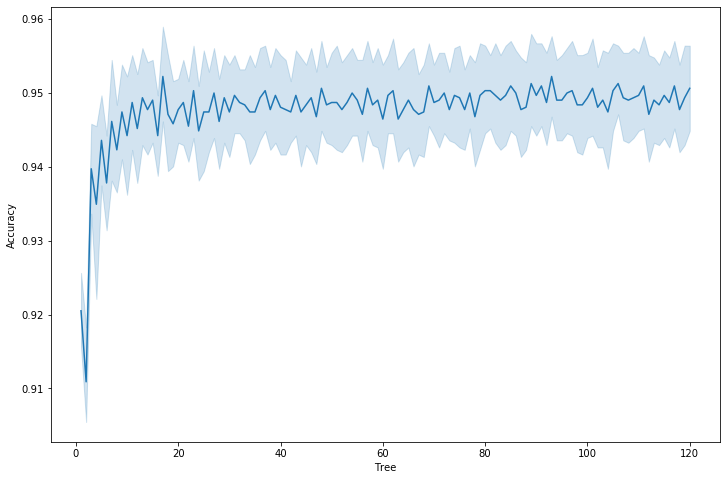

In [8]:
plt.figure(figsize=(12,8))
sns.lineplot(data = grid_acc[grid_acc['In_Bands']=='Spectrum_Normalize_Fourier_Terrain_Meterology'],
             x='Tree',
             y='Accuracy')

##### Observe that the Fourier bands significant increases the accuracy

In [9]:
# get the accuracy with the tree number of 100
Acc_tree_100 = grid_acc[grid_acc['Tree'] == 100]

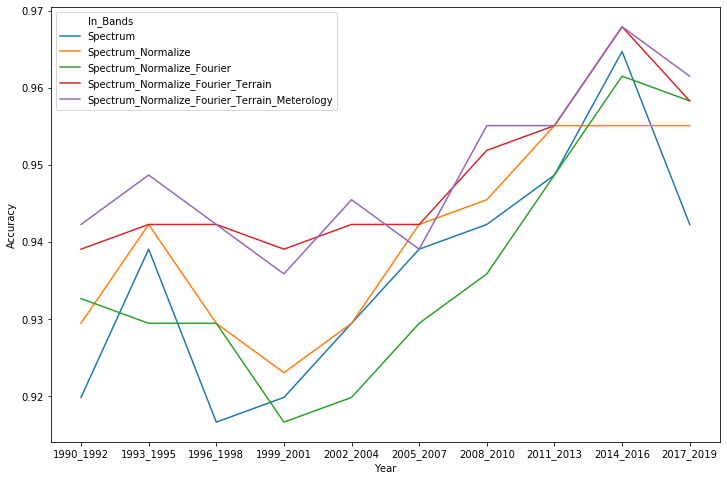

In [10]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Acc_tree_100,
             x='Year',
             y='Accuracy',
             hue = 'In_Bands')

##### Compare all region's accuracy

In [14]:
All_accuracy = []

for region in ['dongbei','huadong','zhongnan','xinan','xibei','huabei','NCP']:
    
    df = pd.read_csv(f'./Result/Grid_acc_tree_{region}.csv')
    df['Region'] = region
    All_accuracy.append(df)

In [15]:
All_accurac_df = pd.concat(All_accuracy,0)
All_accurac_df_tree_100 = All_accurac_df[All_accurac_df['Tree'] == 100]

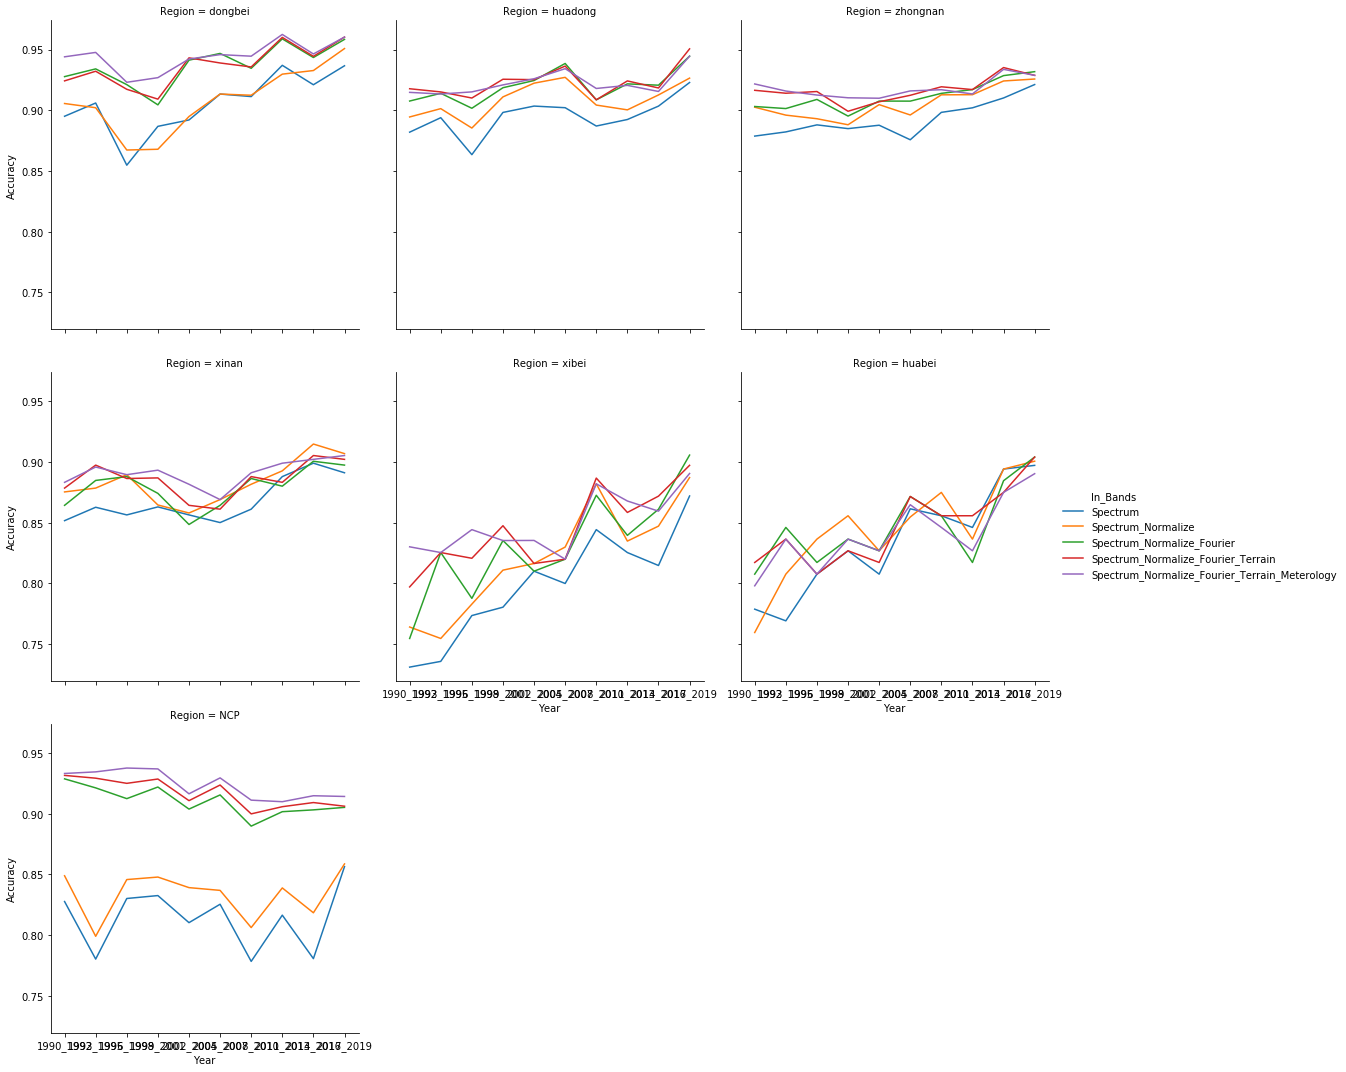

In [16]:
sns.relplot(data=All_accurac_df_tree_100,x='Year',y='Accuracy',hue='In_Bands',col='Region',kind="line",col_wrap=3)